Sentiment analysis with Keras

Flow

- GloVe (Global Vector) embedding -> custom convolution network, with accuracy as the metric; cross-entropy as loss function, rmsprop as optimizer.

Further tuning

- Use different corpus size glove
- Balance the sample of testing as well.  
(We applied weights accounting the skewed distribution of positive comments in training set, but this has to be done on testing set as well...)
- Apply different metric (not only accuracy, like F1-score, AUC...)

Further work

- collect samples not only from steam, but indie game platforms like itch.io


Codes are modified from

(For GloVe embedding and training)
https://keras.io/examples/nlp/pretrained_word_embeddings/

(For binary classification, and imbalance data)
https://keras.io/examples/structured_data/imbalanced_classification/

(TODO)
For oversampling and undersampling -> build a smoother gradient
https://www.tensorflow.org/tutorials/structured_data/imbalanced_data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


from pathlib import Path
import random

random.seed(13)
# take 15% for both testing and training from original. Then among that 15%, 70% for training, 30% for testing.
p = 0.50

# full dataset from Kaggle
# dataset_path = Path('../../dataset/sa/dataset.csv').resolve()

# cleaned dataset
dataset_heartless_path = Path('../../dataset/sa/dataset_cleaned_heartless.pkl').resolve()

# load with random selection
# dataset = pd.read_csv(dataset_path, skiprows=lambda i: i > 0 and random.random() > p)
# dataset.head()


# load cleaned dataset
dataset = pd.read_pickle(dataset_heartless_path)
dataset = dataset.sample(frac=p)
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2445964 entries, 893401 to 2709982
Data columns (total 6 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   index         int64 
 1   app_id        int64 
 2   app_name      object
 3   review_text   object
 4   review_score  int64 
 5   review_votes  int64 
dtypes: int64(4), object(2)
memory usage: 130.6+ MB


In [2]:
# first do data cleaning

# convert to string
dataset['review_text'] = dataset['review_text'].astype('str')

In [3]:
dataset = dataset.drop_duplicates(keep='first')

remove some characters, but not do the stop words, stemming and lemmatizing (no doing them in Keras example ??)

In [4]:
import re

def clean(raw):
    """ Remove hyperlinks and markup """
    result = re.sub("<[a][^>]*>(.+?)</[a]>", 'Link.', raw)
    result = re.sub('&gt;', "", result)
    result = re.sub('&#x27;', "'", result)
    result = re.sub('&quot;', '"', result)
    result = re.sub('&#x2F;', ' ', result)
    result = re.sub('<p>', ' ', result)
    result = re.sub('</i>', '', result)
    result = re.sub('&#62;', '', result)
    result = re.sub('<i>', ' ', result)
    result = re.sub("\n", '', result)
    return result

In [5]:
def remove_num(texts):
   output = re.sub(r'\d+', '', texts)
   return output

In [6]:
def deEmojify(x):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'', x)

In [7]:
def unify_whitespaces(x):
    cleaned_string = re.sub(' +', ' ', x)
    return cleaned_string 

In [8]:
def remove_symbols(x):
    cleaned_string = re.sub(r"[^a-zA-Z0-9?!.,]+", ' ', x)
    return cleaned_string

In [9]:
def remove_punctuation(text):
    final = "".join(u for u in text if u not in ("?", ".", ";", ":",  "!",'"',','))
    return final

In [10]:
def cleaning(df, review_col_name):
    df[review_col_name] = df[review_col_name].apply(clean)
    df[review_col_name] = df[review_col_name].apply(deEmojify)
    df[review_col_name] = df[review_col_name].str.lower()
    df[review_col_name] = df[review_col_name].apply(remove_num)
    df[review_col_name] = df[review_col_name].apply(remove_symbols)
    df[review_col_name] = df[review_col_name].apply(remove_punctuation)

In [11]:
cleaning(dataset, 'review_text')

dataset.head(20)

,index,app_id,app_name,review_text,review_score,review_votes
893401,1050062,215670,Home,though the game has a few technical issues par...,1,0
1252934,1551289,223710,Cry of Fear,find the game s store page download the game ...,1,0
558945,619663,204450,Call of Juarez Gunslinger,awesome game but we need som kind of multiplay...,1,0
3100128,4101955,317410,Color Symphony,for free it is a fun game with a twist on the ...,1,0
2292124,3005325,261030,The Walking Dead: Season Two,cried my eyes out,1,0
3263439,4327608,332800,Five Nights at Freddy's 2,hundreds of youtube playthroughs can t be wron...,1,0
931368,1092032,218620,PAYDAY 2,i played this game for a good amount of time s...,-1,1
1453268,1821408,230410,Warframe,the odd and unique art style can initially be ...,1,0
1170927,1459848,22180,Penumbra: Overture,i would give this game a even though it is no...,1,0
2184243,2879448,253110,The Cat Lady,has good art music and story,1,0


Start our ML

In [12]:
X = dataset['review_text']
y = dataset['review_score']

In [13]:
# convert the '-1' in y to '0'
# s.t. 0 represents 'negative'
# 1 represents 'positive'
y = y.replace(-1, 0)


In [14]:
class_names = y.unique()
print(class_names)

[1 0]


In [15]:
# create 
# split to train and test dataset

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=13, test_size=0.3)

In [16]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization

vectorizer = TextVectorization(max_tokens=20000, output_sequence_length=200)
text_ds = tf.data.Dataset.from_tensor_slices(X_train).batch(128)
vectorizer.adapt(text_ds)

2023-11-07 23:44:02.401650: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-07 23:44:02.570729: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-07 23:44:02.570756: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-07 23:44:02.571565: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-07 23:44:02.656601: I tensorflow/core/platform/cpu_feature_g

In [17]:
vectorizer.get_vocabulary()[:5]

['', '[UNK]', 'the', 'and', 'a']

In [18]:
output = vectorizer([["the game looks awesome"]])
output.numpy()[0, :6]

array([  2,   6, 325, 147,   0,   0])

load pre-trained word embeddings

Download glove dataset and place it according to the argument in Path() object

In [19]:
# glove_file_path = Path("glove.6B/glove.6B.100d.txt").resolve()
glove_file_path = Path("../glove.6B/glove.6B.100d.txt").resolve()

embeddings_index = {}
with open(glove_file_path) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


Now, let's prepare a corresponding embedding matrix that we can use in a Keras Embedding layer. 

It's a simple NumPy matrix where entry at index i is the pre-trained vector for the word of index i in our vectorizer's vocabulary.

In [20]:
voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

num_tokens = len(voc) + 2
embedding_dim = 100
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
        
print("Converted %d words (%d misses)" % (hits, misses))

Converted 18253 words (1747 misses)


Next, we load the pre-trained word embeddings matrix into an Embedding layer.

Note that we set trainable=False so as to keep the embeddings fixed (we don't want to update them during training).

In [21]:
import keras
from tensorflow.keras.layers import Embedding

embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
)

Build the model

A simple 1D convnet with global max pooling and a classifier at the end.

In [22]:
from tensorflow.keras import layers

int_sequences_input = keras.Input(shape=(None,), dtype="int64")
embedded_sequences = embedding_layer(int_sequences_input)
x = layers.Conv1D(128, 5, activation="relu")(embedded_sequences)
x = layers.MaxPooling1D(5)(x)
x = layers.Conv1D(128, 5, activation="relu")(x)
x = layers.MaxPooling1D(5)(x)
x = layers.Conv1D(128, 5, activation="relu")(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.5)(x)
preds = layers.Dense(len(class_names), activation="softmax")(x)           # for multi-class probability output
# preds = layers.Dense(1, activation='sigmoid')(x)                             # for single-class output

initialize the models

In [25]:
model_classweight = keras.Model(int_sequences_input, preds)
model_classweight.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 100)         2000200   
                                                                 
 conv1d (Conv1D)             (None, None, 128)         64128     
                                                                 
 max_pooling1d (MaxPooling1  (None, None, 128)         0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, None, 128)         82048     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, None, 128)         0         
 g1D)                                                        

In [23]:
model_oversampling = keras.Model(int_sequences_input, preds)
model_oversampling.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 100)         2000200   
                                                                 
 conv1d (Conv1D)             (None, None, 128)         64128     
                                                                 
 max_pooling1d (MaxPooling1  (None, None, 128)         0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, None, 128)         82048     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, None, 128)         0         
 g1D)                                                        

-----

Before training, we need to address the imbalance nature of the (training) dataset

In [24]:
print('reviews ratio:')
print(y_train.value_counts(normalize=True))

print('\n\n')

print('reviews count')
print(y_train.value_counts())

reviews ratio:
review_score
1    0.84028
0    0.15972
Name: proportion, dtype: float64



reviews count
review_score
1    1438705
0     273469
Name: count, dtype: int64


## Approach 01 - Class weights

In [29]:
# we create the weights for training
inverse_func = lambda x: 1 / x
class_weight_training = dict(
    (k, inverse_func(v)) for k, v in dict(y_train.value_counts(normalize=True)).items()
)

print(class_weight_training)

class_weight_testing = dict(
    (k, inverse_func(v)) for k, v in dict(y_test.value_counts(normalize=True)).items()
)

print(class_weight_testing)

{1: 1.2149932289917673, 0: 5.651309274666939}
{1: 1.2157109915449653, 0: 5.635832383124288}


Over 80% reviews are positive. We need to balance them s.t. each classes are equally distributed in both training and evaluation data.

Or we pass parameter _class_weight_ to the Keras during training.

Train the model

In [30]:
# we first vectorize the strings (i.e. embedding) for passing to the training pipeline 

X_train_vec = vectorizer(np.array([[s] for s in X_train])).numpy()
X_test_vec = vectorizer(np.array([[s] for s in X_test])).numpy()

y_train_arr = np.array(y_train)
y_test_arr = np.array(y_test)

get_test_weight = lambda x: class_weight_testing[x]
y_test_weight = np.array([get_test_weight(x) for x in y_test_arr])

: 

In [28]:
print(y_test_arr.shape)
print(y_test_weight.shape)

(237246,)
(237246,)


In [29]:
X_train_vec.shape

(553574, 200)

We use categorical crossentropy as our loss since we're doing softmax classification. 

Moreover, we use sparse_categorical_crossentropy since our labels are integers.

In [38]:
# TODO: add more metrics
# examples
metrics = [
    keras.metrics.SparseCategoricalAccuracy(),
    # keras.metrics.FalseNegatives(name="fn", thresholds=0),
    # keras.metrics.FalsePositives(name="fp"),
    # keras.metrics.TrueNegatives(name="tn"),
    # keras.metrics.TruePositives(name="tp"),
    # keras.metrics.Precision(name="precision"),
    # keras.metrics.Recall(name="recall")
]
model_classweight.compile(
    loss="sparse_categorical_crossentropy", optimizer='adam', metrics=metrics, weighted_metrics=keras.metrics.SparseCategoricalAccuracy('sparse_categorical_accuracy_weighted')
)

# model.compile(
#     loss='binary_crossentropy', optimizer='rmsprop', weighted_metrics=metrics
# )

# apply early stopping to avoid overfit
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)


# try to use weighted samples to avoid data imbalance
# so as the test
history_classweight = model_classweight.fit(
    X_train_vec, 
    y_train_arr, 
    batch_size=128,                 # TODO: test changing the batch size to include negative samples at each batch (update gradient...) 
    epochs=20, 
    validation_data=(X_test_vec, y_test_arr, y_test_weight), 
    class_weight=class_weight_training,
    callbacks=[callback]
)

Epoch 1/20


2023-09-17 23:01:08.563602: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4325/4325 [==============================] - ETA: 0s - loss: 0.8252 - sparse_categorical_accuracy: 0.8335 - sparse_categorical_accuracy_weighted: 0.8352

2023-09-17 23:01:59.500289: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4325/4325 [==============================] - 62s 14ms/step - loss: 0.8252 - sparse_categorical_accuracy: 0.8335 - sparse_categorical_accuracy_weighted: 0.8352 - val_loss: 0.7753 - val_sparse_categorical_accuracy: 0.8515 - val_sparse_categorical_accuracy_weighted: 0.8412
Epoch 2/20
4325/4325 [==============================] - 65s 15ms/step - loss: 0.9031 - sparse_categorical_accuracy: 0.8333 - sparse_categorical_accuracy_weighted: 0.8340 - val_loss: 0.8736 - val_sparse_categorical_accuracy: 0.7923 - val_sparse_categorical_accuracy_weighted: 0.8334
Epoch 3/20
4325/4325 [==============================] - 62s 14ms/step - loss: 0.9508 - sparse_categorical_accuracy: 0.8303 - sparse_categorical_accuracy_weighted: 0.8303 - val_loss: 0.7805 - val_sparse_categorical_accuracy: 0.8503 - val_sparse_categorical_accuracy_weighted: 0.8444
Epoch 4/20
4325/4325 [==============================] - 61s 14ms/step - loss: 1.0900 - sparse_categorical_accuracy: 0.8275 - sparse_categorical_accuracy_weighted: 0.

Check training hsitory, plot related stuff

In [39]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# func from: https://www.tensorflow.org/tutorials/structured_data/imbalanced_data

def plot_metrics(history):
  metrics = ['loss', 'sparse_categorical_accuracy']
  plt.style.use('dark_background')
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

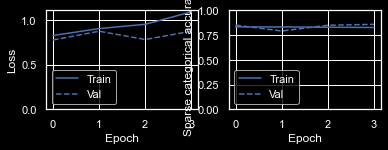

In [40]:
plot_metrics(history_classweight)

Evaluation using test dataset

Plot the confusion matrix

In [65]:
from sklearn.metrics import confusion_matrix

def plot_cm(labels, predictions):
  cm = confusion_matrix(labels, predictions)
  sns.heatmap(cm, annot=True, fmt='')

  plt.title('Confusion matrix')
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('True Negatives: ', cm[0][0])
  print('False Positives: ', cm[0][1])
  print('False Negatives: ', cm[1][0])
  print('True Positives: ', cm[1][1])
  print('Total number of samples: ', np.sum(cm[1]))

In [ ]:
results_classweights = model_classweight.evaluate(X_test_vec, y_test_arr, batch_size = 128, verbose=0)

# for name, value in zip(model_classweight.metrics_name)

## Approach 02: Oversampling/Umdersampling

one can use numpy (to just randomly select data from class with larger number of data)

or use imbalanced-learn package to do oversampling and undersampling

or use tensorflow.data class

personally imbalanced-learn package will be better for cross ml-platform data preparation. It supports sklearn, and also numpy operation, which after preparing the data, we can build the tf dataset/pytorch dataset class.

In [ ]:
# have to convert the X_train, X_test to numpy before passing to the oversampling/undersampling pipeline

# X_train_np = X_train.to_numpy().reshape(-1, 1)

In [25]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

# X_train, X_test, y_train, y_test

# oversampling = RandomOverSampler(sampling_strategy=0.5)     # raise the ratio minority_data:majority_data as 1 (i.e. equal number of samples)
under = RandomUnderSampler(sampling_strategy=1.0)          # then select ? of it

# X_train_resampled, y_train_resampled = oversampling.fit_resample(X_train.to_numpy().reshape(-1, 1), y_train.to_numpy().reshape(-1, 1))
# X_train_resampled, y_train_resampled = under.fit_resample(X_train_resampled, y_train_resampled)

X_train_resampled, y_train_resampled = under.fit_resample(X_train.to_numpy().reshape(-1, 1), y_train.to_numpy().reshape(-1, 1))

In [26]:
print(X_train_resampled.shape)
print(y_train_resampled.shape)

(546938, 1)
(546938,)


In [27]:
# the shape is not correct -> squeeze to reduce the dimension
X_train_resampled = np.squeeze(X_train_resampled)

In [28]:
X_train_resampled

array(['the good life is a great idea that is barely realized there s nothing to manage in this game property can only be purchased at random and you can only buy one boat at a time there s little to do in this game but ferry people around from one point to another sure there s diving and fishing but they re rarely worth the effort once i realized that the game was far more shallow than it let on it was hard to play it to the end there s supposed to be an end state but after almost thirty hours i haven t seen it yet look i paid a dollar for it but i ll be honest it ain t that good your time is worth more than this',
       'this game crashed pls fix ',
       'another look pretty no substance game', ...,
       'one of the best td games i ve ever played trying to beat the level for a couple of hours that s when i call td game is a success to win flawlessly you need to develop a tactic if you are successful with story  you can try challenges and i must say they are very tricky to win bu

### TODO: need to convert to tf.data.Dataset object to save memory :D

In [29]:
# vectorize the strings in the new resampled array 

X_train_reasampled_vec = vectorizer(np.array([[s] for s in X_train_resampled])).numpy()
X_test_vec = vectorizer(np.array([[s] for s in X_test])).numpy()

y_train_resampled_arr = y_train_resampled
y_test_arr = np.array(y_test)

In [30]:
print(X_train_reasampled_vec.shape)
print(y_train_resampled_arr.shape)

(546938, 200)
(546938,)


In [31]:
# copy from the cell above

# TODO: add more metrics
# examples
metrics = [
    keras.metrics.SparseCategoricalAccuracy(),
    # keras.metrics.FalseNegatives(name="fn", thresholds=0),
    # keras.metrics.FalsePositives(name="fp"),
    # keras.metrics.TrueNegatives(name="tn"),
    # keras.metrics.TruePositives(name="tp"),
    # keras.metrics.Precision(name="precision"),
    # keras.metrics.Recall(name="recall")
]
model_oversampling.compile(
    loss="sparse_categorical_crossentropy", optimizer='adam', metrics=metrics, weighted_metrics=keras.metrics.SparseCategoricalAccuracy('sparse_categorical_accuracy_weighted')
)

# model.compile(
#     loss='binary_crossentropy', optimizer='rmsprop', weighted_metrics=metrics
# )

# apply early stopping to avoid overfit
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)


# try to use weighted samples to avoid data imbalance
# so as the test
history_oversampling = model_oversampling.fit(
    X_train_reasampled_vec, 
    y_train_resampled_arr, 
    batch_size=128,                 # TODO: test changing the batch size to include negative samples at each batch (update gradient...) 
    epochs=20, 
    validation_data=(X_test_vec, y_test_arr),
    callbacks=[callback]
)

Epoch 1/20


2023-11-07 23:46:15.532699: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8900
2023-11-07 23:46:16.152912: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f82b81a7240 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-07 23:46:16.152935: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2023-11-07 23:46:16.157581: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-07 23:46:16.212790: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


4273/4273 [==============================] - 28s 6ms/step - loss: 0.3822 - sparse_categorical_accuracy: 0.8266 - sparse_categorical_accuracy_weighted: 0.8266 - val_loss: 0.3235 - val_sparse_categorical_accuracy: 0.8532 - val_sparse_categorical_accuracy_weighted: 0.8532
Epoch 2/20
4273/4273 [==============================] - 25s 6ms/step - loss: 0.3210 - sparse_categorical_accuracy: 0.8618 - sparse_categorical_accuracy_weighted: 0.8618 - val_loss: 0.3065 - val_sparse_categorical_accuracy: 0.8691 - val_sparse_categorical_accuracy_weighted: 0.8691
Epoch 3/20
4273/4273 [==============================] - 25s 6ms/step - loss: 0.2980 - sparse_categorical_accuracy: 0.8737 - sparse_categorical_accuracy_weighted: 0.8737 - val_loss: 0.2487 - val_sparse_categorical_accuracy: 0.8975 - val_sparse_categorical_accuracy_weighted: 0.8975
Epoch 4/20
4273/4273 [==============================] - 25s 6ms/step - loss: 0.2822 - sparse_categorical_accuracy: 0.8818 - sparse_categorical_accuracy_weighted: 0.8818

In [33]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# func from: https://www.tensorflow.org/tutorials/structured_data/imbalanced_data

def plot_metrics(history):
  metrics = ['loss', 'sparse_categorical_accuracy']
  plt.style.use('dark_background')
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()


In [ ]:
plot_metrics(history_classweight)

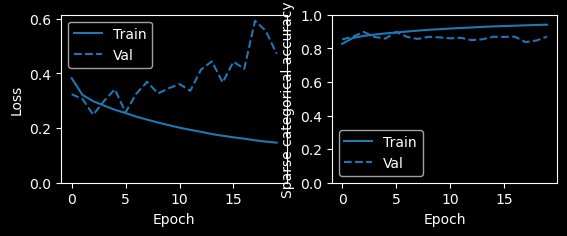

In [34]:
plot_metrics(history_oversampling)

## Evaluation

In [67]:
from sklearn.metrics import confusion_matrix

from seaborn import set
from seaborn import set_style

set_style("darkgrid")

def plot_cm(labels, predictions):
  # cm = confusion_matrix(labels, predictions > threshold)
  cm = confusion_matrix(labels, predictions)
  plt.figure(figsize=(12,12))
  sns.heatmap(cm, annot=True, fmt='', square=True,  annot_kws={"size":12})
  plt.title('Confusion matrix')
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('True Negatives: ', cm[0][0])
  print('False Positives: ', cm[0][1])
  print('False Negatives: ', cm[1][0])
  print('True Positives: ', cm[1][1])
  print('Total number of samples: ', np.sum(cm))

In [ ]:
# run the model and collect predictions on test dataset

In [36]:
# run the model and collect predictions on test dataset

test_predictions_oversampling_rawprob = model_oversampling.predict(X_test_vec, batch_size=128)

5733/5733 [==============================] - 6s 1ms/step


In [38]:
print(test_predictions_oversampling_rawprob)
print(test_predictions_oversampling_rawprob.shape)

[[3.2976708e-11 1.0000000e+00]
 [6.1081861e-05 9.9993896e-01]
 [1.0000000e+00 1.5243818e-11]
 ...
 [5.4042763e-01 4.5957243e-01]
 [9.9999928e-01 6.8079322e-07]
 [2.0294396e-02 9.7970563e-01]]
(733790, 2)


In [39]:
# since the output is a probability instead of a single label
# we need to convert that to a single 0 or 1 class
test_predictions_oversampling = np.argmax(test_predictions_oversampling_rawprob, axis=1)

# creating single class label probability for ploting ROC curve
test_predictions_oversampling_prob =  test_predictions_oversampling_rawprob if len(np.unique(y_test)) > 2 else np.array([test_predictions_oversampling_rawprob[i, pred] for i, pred in enumerate(list(test_predictions_oversampling))])

In [40]:
print(test_predictions_oversampling)
print(test_predictions_oversampling.shape)
print()
print(test_predictions_oversampling_prob)
print(test_predictions_oversampling_prob.shape)

[1 1 0 ... 0 0 1]
(733790,)

[1.         0.99993896 1.         ... 0.5404276  0.9999993  0.97970563]
(733790,)


In [41]:
results_oversampling = model_oversampling.evaluate(X_test_vec, y_test_arr, batch_size = 128, verbose=0)

for name, value in zip(model_oversampling.metrics_names, results_oversampling):
    print('{}: {}'.format(name, value))

loss: 0.47132810950279236
sparse_categorical_accuracy: 0.8698319792747498
sparse_categorical_accuracy_weighted: 0.8698319792747498


True Negatives:  98484
False Positives:  19129
False Negatives:  76387
True Positives:  539790
Total number of samples:  733790


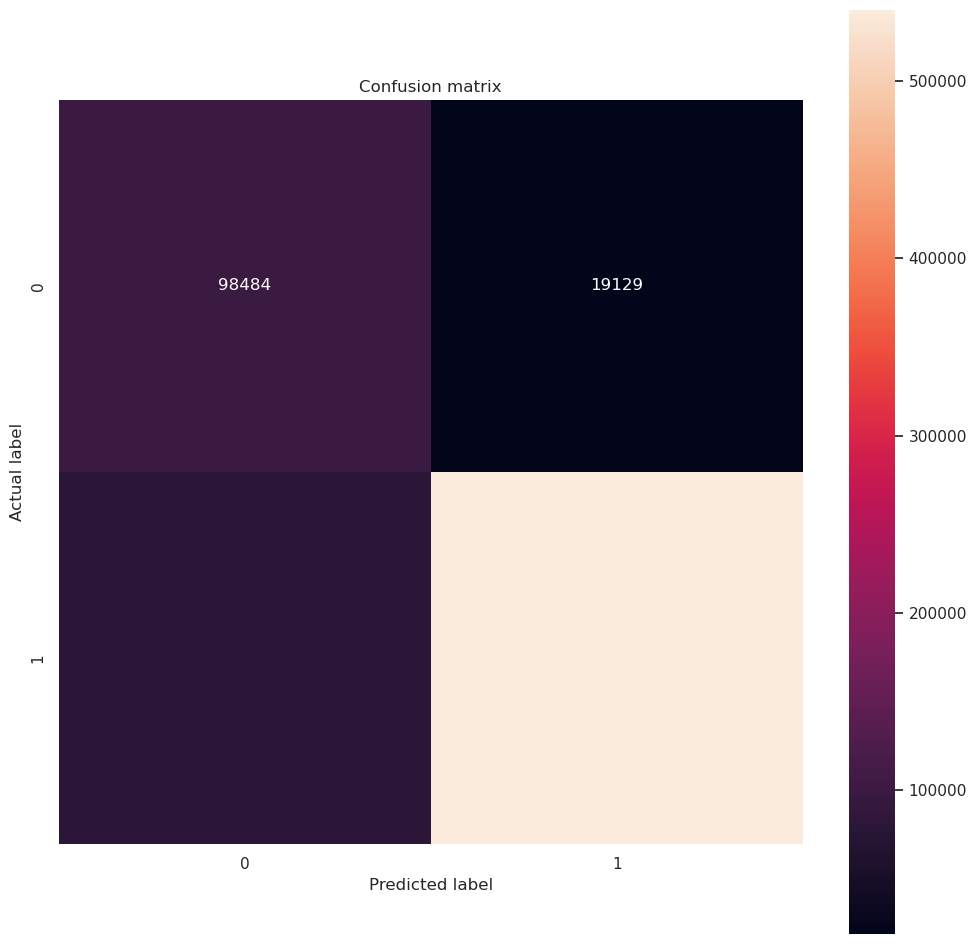

In [71]:
plot_cm(y_test_arr, test_predictions_oversampling)

In [52]:
confusion_matrix(y_test_arr, test_predictions_oversampling)

array([[ 98484,  19129],
       [ 76387, 539790]])

In [45]:
# plot ROC curve for binary class classification

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score
from datetime import datetime

def plot_roc_curve_binary(y_test, y_pred, title=None, save=False):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(2):
        fpr[i], tpr[i], _ = roc_curve(y_test, y_pred)
        roc_auc[i] = auc(fpr[i], tpr[i])

    print(roc_auc_score(y_test, y_pred))
    plt.figure(dpi=600)
    plt.plot(fpr[1], tpr[1], label="ROC curve (area = {:0.4f})".format(roc_auc_score(y_test, y_pred)))

    # random-guess line
    plt.plot([0, 1], [0, 1], "k--")

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title if title else 'Receiver operating characteristic (ROC)')
    plt.legend(loc='lower right')

    if save:
        plt.savefig(f'steam-games-reviews-analysis-sentiment-analysis_ROC-curve_{datetime.now().strftime("%Y%m%d%H%M%S")}.png', dpi=600, facecolor='w')

    # plt.show() should come AFTER than plt.savefig
    # as plt.show() clears the whole thing -> anything after wards will happen on a new blank figure
    plt.show()

0.5567019260973333


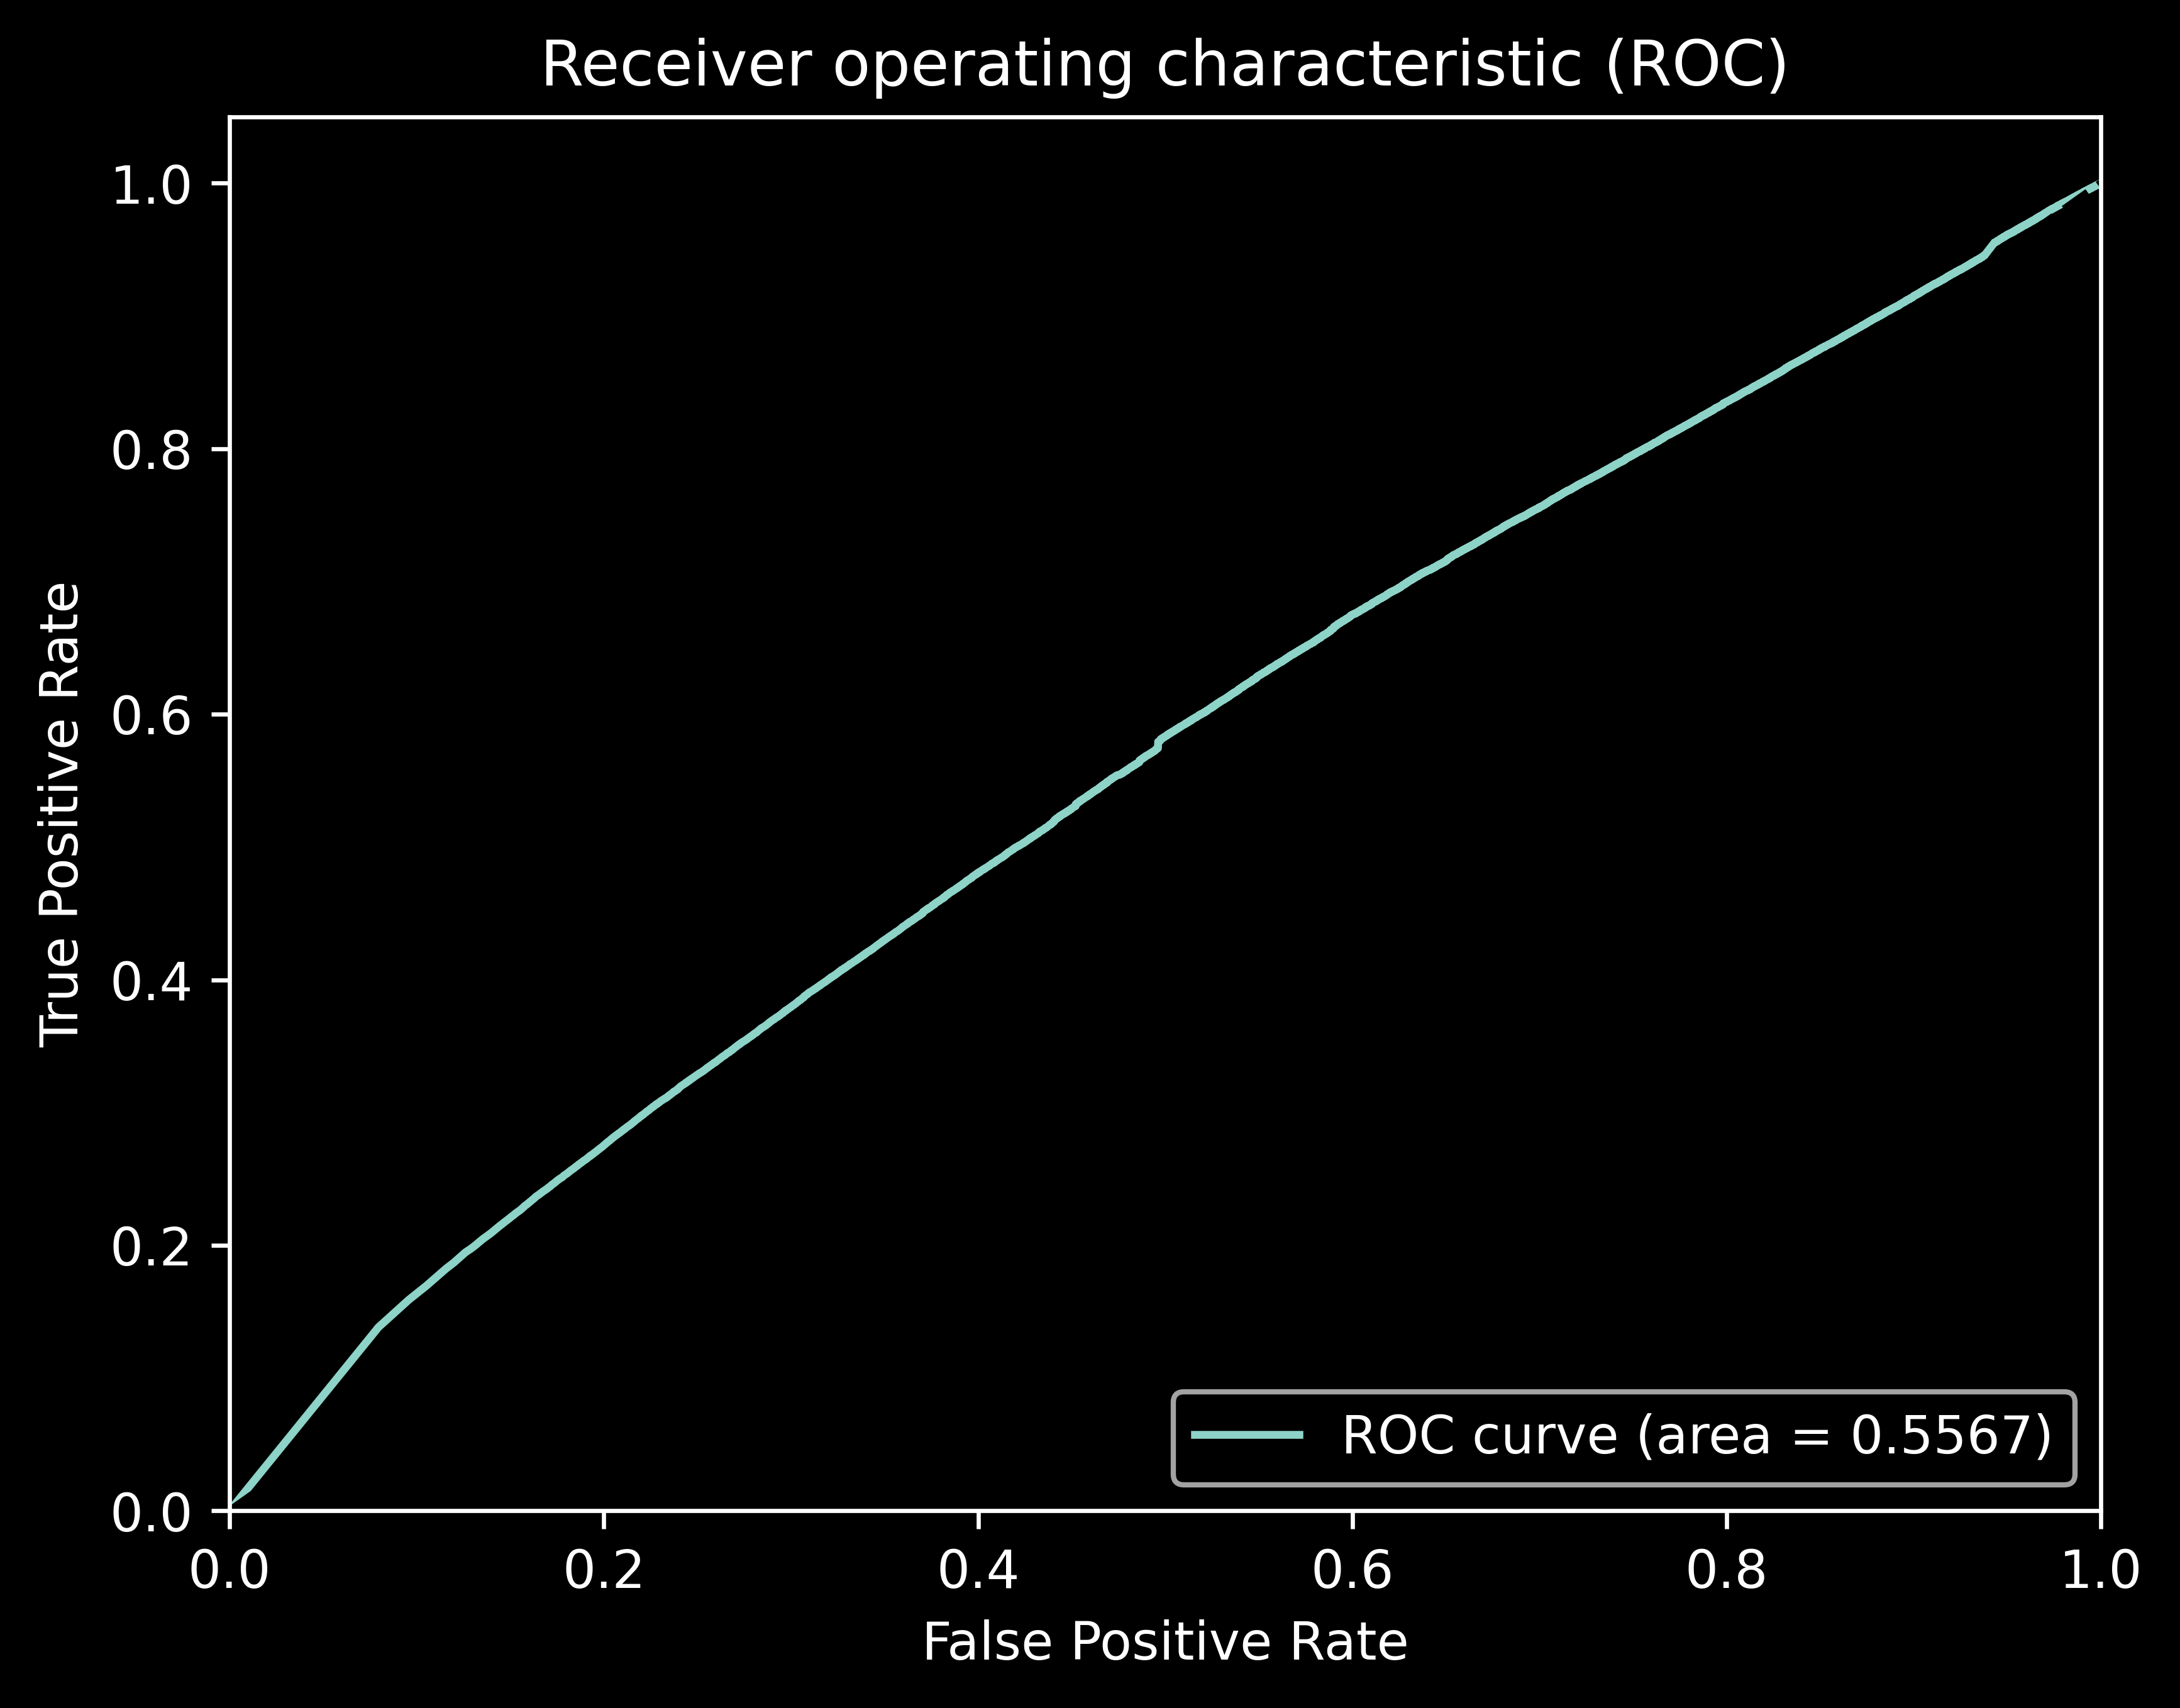

In [47]:
# predictions_probability = np.array([for label, prob in zip(test_predictions_oversampling_logit, test_predictions_oversampling)])

plot_roc_curve_binary(
    y_test_arr, test_predictions_oversampling_prob
)

------

Export an end-to-end model

Now, we may want to export a Model object that takes as input a string of arbitrary length, rather than a sequence of indices. It would make the model much more portable, since you wouldn't have to worry about the input preprocessing pipeline.

Our vectorizer is actually a Keras layer, so it's simple:

In [47]:
string_input = keras.Input(shape=(1,), dtype="string")
x = vectorizer(string_input)
preds = model(x)
end_to_end_model = keras.Model(string_input, preds)

1/1 [==============================] - 0s 99ms/step
[5.488087e-04 9.994512e-01]


2023-09-17 23:09:07.386334: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [51]:
# positive reviews
# the third one is an actual postitive review from AC6
# https://steamcommunity.com/id/bromancedance/recommended/1888160/

probabilities = end_to_end_model.predict(
    [["The game deserves a game of the year"], ["I enjoy playing it very much"], ["Fun, FUN, FUN!!!!!! Souls is one of my favorite series of all time, but never tried an AC game before this one. This game is the most fun I've had in a game in so long. Not just the high points, but the pacing just keeps you in the fun seat CONSTANTLY. After playing Starfield and Baldurs Gate 3 recently it felt ILLEGAL how often I was having a blast. I was constantly ready for the point of the game where the fun would slow down, but it only ramps up. TRULY a breath of fresh air in todays gaming climate."]]
)

for prob in probabilities:
    print('output:', prob, '; class:', np.argmax(prob))

1/1 [==============================] - 0s 23ms/step


[[5.4880651e-04 9.9945122e-01]
 [1.1482235e-01 8.8517767e-01]
 [2.0211273e-05 9.9997973e-01]]


In [52]:
# negative reviews
# the second one: https://steamcommunity.com/id/x-pert_bandit/recommended/1091500/
# the third one: https://steamcommunity.com/profiles/76561197960511970/recommended/1716740/

probabilities = end_to_end_model.predict(
    [["Buying this game is wasting my money."], ["Now before all else is said, it is a good game, if it wasn't I wouldn't have put in so many hours elsewise. But save your cash until they've fixed a majority of the bugs and optimized it a bit more."], ["It is not a bad game. If you want Fallout in Space with dogfights, it absolutely delivers that. But the problems are that it feels very dated. The voice-acting and writing are embarrassingly bad, especially after coming off Baldurs Gate 3 where I found myself caring deeply about the characters and their stories. Starfield makes me want to skip dialog as fast as possible because it is so cringey. The main plot is about as cliched and uninspired as you can imagine. You are a no-name miner, but suddenly you are the crux of the whole plot and everyone just decides to make you the chosen one to do all the important stuff in a pre-existing group for no reason at all. It makes absolutely no sense when they had someone in their organization who had already experienced the mcguffin. The more I play it, the less I like it from the plot perspective. If people aren't playing for the plot, their experience will likely be better, but I still find the game feeling dated... Looks like I've played too much to refund it, which is disappointing, but the same issues still remain. The writing and voice-acting are reminiscent of a game from 1995 and really hold this game back."]]
)

for prob in probabilities:
    print('output:', prob, '; class:', np.argmax(prob))

1/1 [==============================] - 0s 25ms/step
output: [0.99312115 0.00687893] ; class: 0
output: [0.02755235 0.9724477 ] ; class: 1
output: [0.9895983  0.01040172] ; class: 0


Save the model

In [53]:
end_to_end_model.save("keras_16-09-2023.keras")

------

load the model and test its inference.

In [54]:
loaded_model = tf.keras.saving.load_model("keras_16-09-2023.keras")

text = "I enjoy the game."

assert np.allclose(end_to_end_model.predict([[text]]), loaded_model.predict([[text]]))

1/1 [==============================] - 0s 104ms/step


2023-09-17 23:23:36.196972: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
